In [52]:
import anndata
import pandas
import scanpy
import scvi
import torch
import numpy
import seaborn
import loupepy
import scipy
import matplotlib
import random
from matplotlib import pyplot

You apparently have to sell your soul to 10x Genomics to write a loupe file.

In [2]:
loupepy.setup()

This tool is independently maintained, but utilizes 10x genomics tools to perform conversions
By using this tool, you agree to the 10X Genomics End User License Agreement (https://www.10xgenomics.com/legal/end-user-software-license-agreement ).
Do you agree to the terms of the EULA? (yes/y or no/n)


In [3]:
working_dir = "../working_dir/"

# This should be one of the output directories of the R script.
h5ad_dir = "cellbender_h5ad/expect_10k_tuned_v4/background_removed/"

genotype = "wildtype"

stage = "a0"

out_file_prefix = genotype + "_" + stage

Concatenate both samples for the stage. Any QC cutoffs should (hopefully) be similar and this way we don't have to look at so many plots.

In [4]:
adata_s1 = anndata.io.read_h5ad(working_dir + h5ad_dir + genotype + "_" + stage + "_s1.h5ad")
adata_s2 = anndata.io.read_h5ad(working_dir + h5ad_dir + genotype + "_" + stage + "_s2.h5ad")

adata = anndata.concat([adata_s1,
                        adata_s2],
                       join='outer')  # Outer join prevents the removal of genes that aren't expressed in every library
adata

AnnData object with n_obs × n_vars = 20910 × 17609
    obs: 'library_id', 'genotype', 'stage', 'sample', 'study', 'spliced_counts', 'unspliced_counts', 'ambiguous_counts', 'fraction_unspliced_ambiguous', 'fraction_unspliced_unambiguous'

Just checking how many nuclei we are starting with.

In [5]:
adata.obs["library_id"].value_counts(sort = False)

library_id
wildtype_a0_s1    11953
wildtype_a0_s2     8957
Name: count, dtype: int64

This shows the highest count genes, summed across all nucelei. Due to including multimappers, the pre-rRNA is an extreme outlier so we remove it. This effects size factor calculation in the normalization step but I'm not yet sure if this is a good idea.

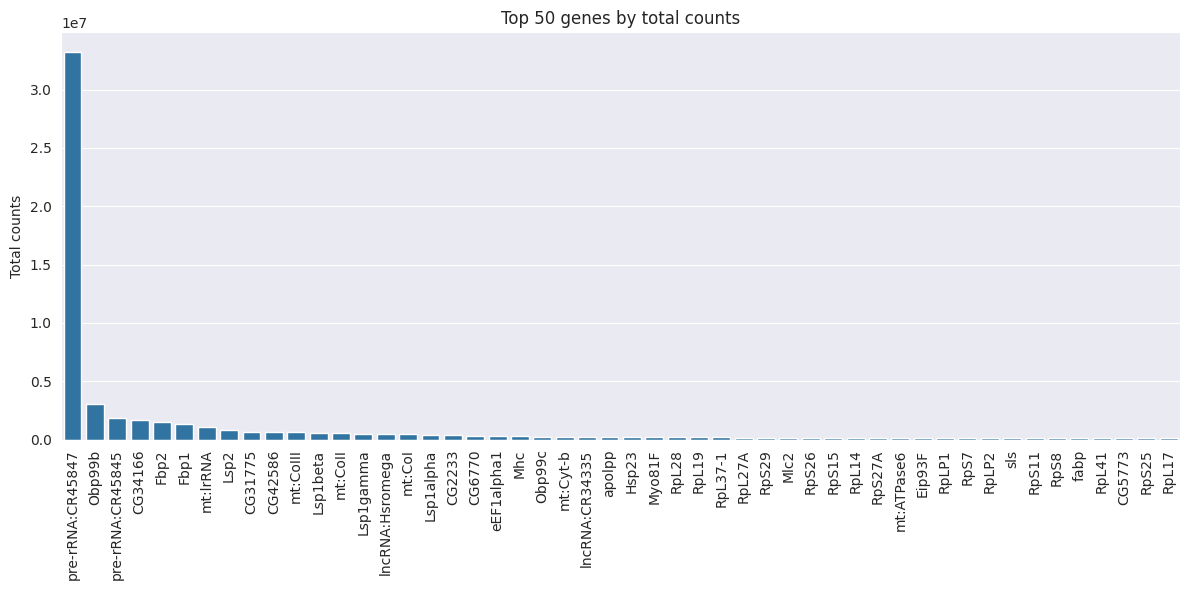

In [6]:
top_n = 50

sums = numpy.asarray(adata.X.sum(axis=0)).ravel()

top_idx = numpy.argsort(sums)[::-1][:top_n]

df_top = pandas.DataFrame({"gene": adata.var_names[top_idx], "total_count": sums[top_idx]})

pyplot.figure(figsize=(12, 6))
seaborn.barplot(x="gene", y="total_count", data=df_top, color="C0")
pyplot.xticks(rotation=90)
pyplot.ylabel("Total counts")
pyplot.xlabel("")
pyplot.title(f"Top {top_n} genes by total counts")
pyplot.tight_layout()
pyplot.show()

In [7]:
adata = adata[:, [g for g in adata.var_names if g not in {"pre-rRNA:CR45847", "pre-rRNA:CR45845"}]]

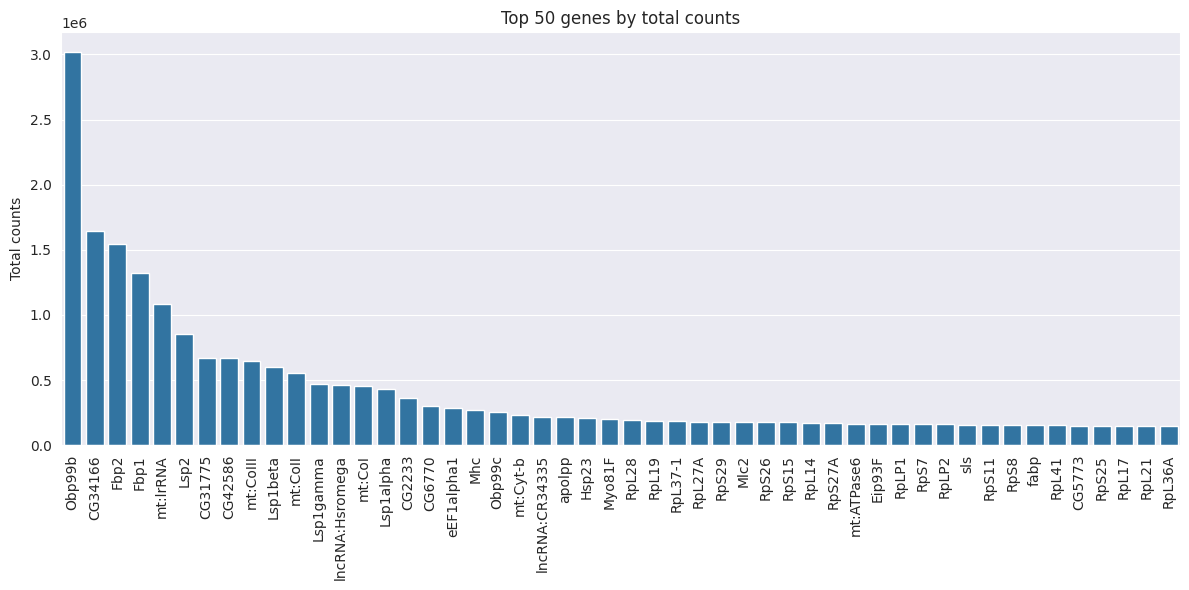

In [8]:
top_n = 50

sums = numpy.asarray(adata.X.sum(axis=0)).ravel()

top_idx = numpy.argsort(sums)[::-1][:top_n]

df_top = pandas.DataFrame({"gene": adata.var_names[top_idx], "total_count": sums[top_idx]})

pyplot.figure(figsize=(12, 6))
seaborn.barplot(x="gene", y="total_count", data=df_top, color="C0")
pyplot.xticks(rotation=90)
pyplot.ylabel("Total counts")
pyplot.xlabel("")
pyplot.title(f"Top {top_n} genes by total counts")
pyplot.tight_layout()
pyplot.show()

Loading the premade gene lists and plotting QC metrics.

In [9]:
mtRNA = pandas.read_csv("../preprocessing/symbol_mtRNA.csv", header = None)[0].tolist()
rRNA = pandas.read_csv("../preprocessing/symbol_rRNA_no_pre.csv", header = None)[0].tolist()
ribo_protein = pandas.read_csv("../preprocessing/symbol_ribo_protein.csv", header = None)[0].tolist()
mito_ribo_protein = pandas.read_csv("../preprocessing/symbol_mito_ribo_protein.csv", header = None)[0].tolist()

adata.var["mtRNA"] = adata.var_names.isin(mtRNA)
adata.var["rRNA"] = adata.var_names.isin(rRNA)
adata.var["ribo_protein"] = adata.var_names.isin(ribo_protein)
adata.var["mito_ribo_protein"] = adata.var_names.isin(mito_ribo_protein)
adata.var["all_ribo_protein"] = adata.var_names.isin(ribo_protein) | adata.var_names.isin(mito_ribo_protein)

/tmp/ipykernel_2179269/2096820658.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mtRNA"] = adata.var_names.isin(mtRNA)


In [10]:
scanpy.pp.calculate_qc_metrics(adata,
                               qc_vars=["mtRNA", "rRNA", "ribo_protein", "mito_ribo_protein", "all_ribo_protein"],
                               inplace=True)

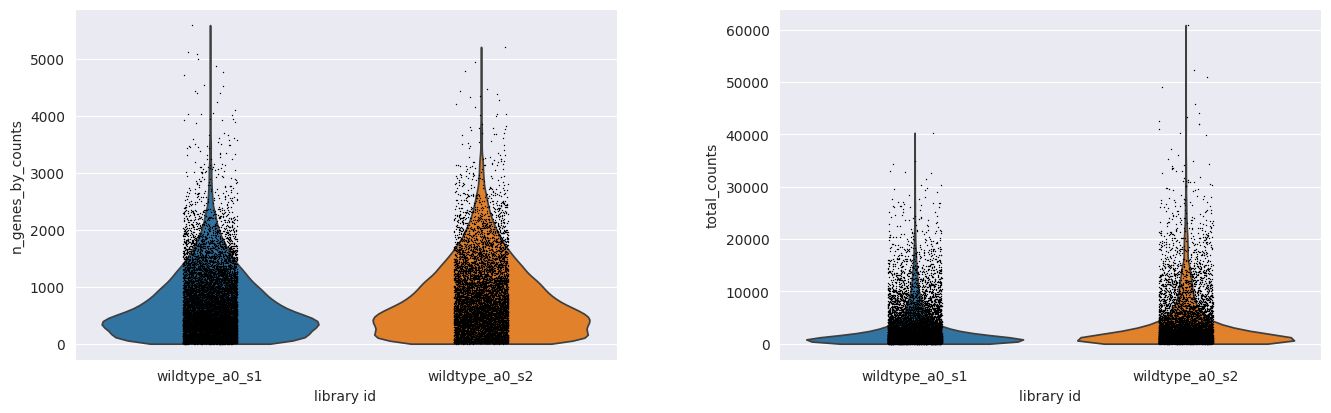

In [11]:
scanpy.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    groupby="library_id",
    multi_panel=True,
)

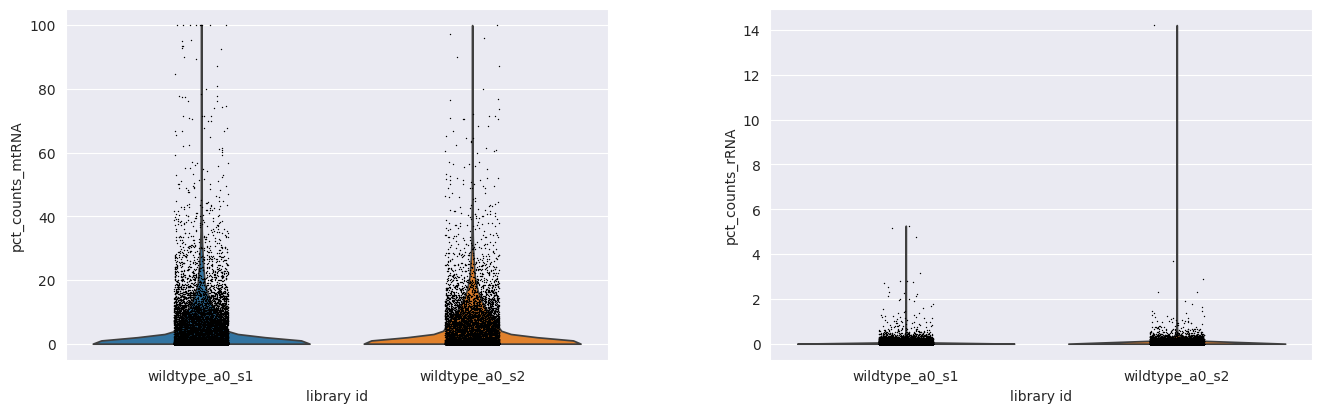

In [12]:
scanpy.pl.violin(
    adata,
    ["pct_counts_mtRNA", "pct_counts_rRNA"],
    groupby="library_id",
    multi_panel=True,
)

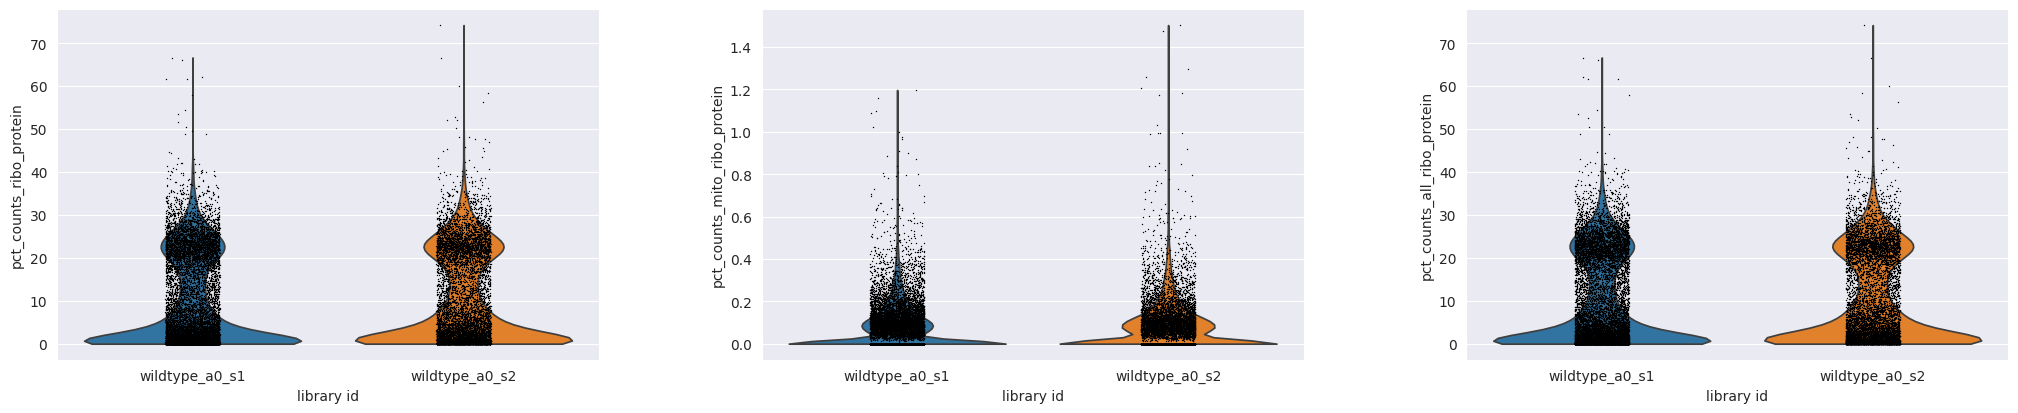

In [13]:
scanpy.pl.violin(
    adata,
    ["pct_counts_ribo_protein", "pct_counts_mito_ribo_protein", "pct_counts_all_ribo_protein"],
    groupby="library_id",
    multi_panel=True,
)

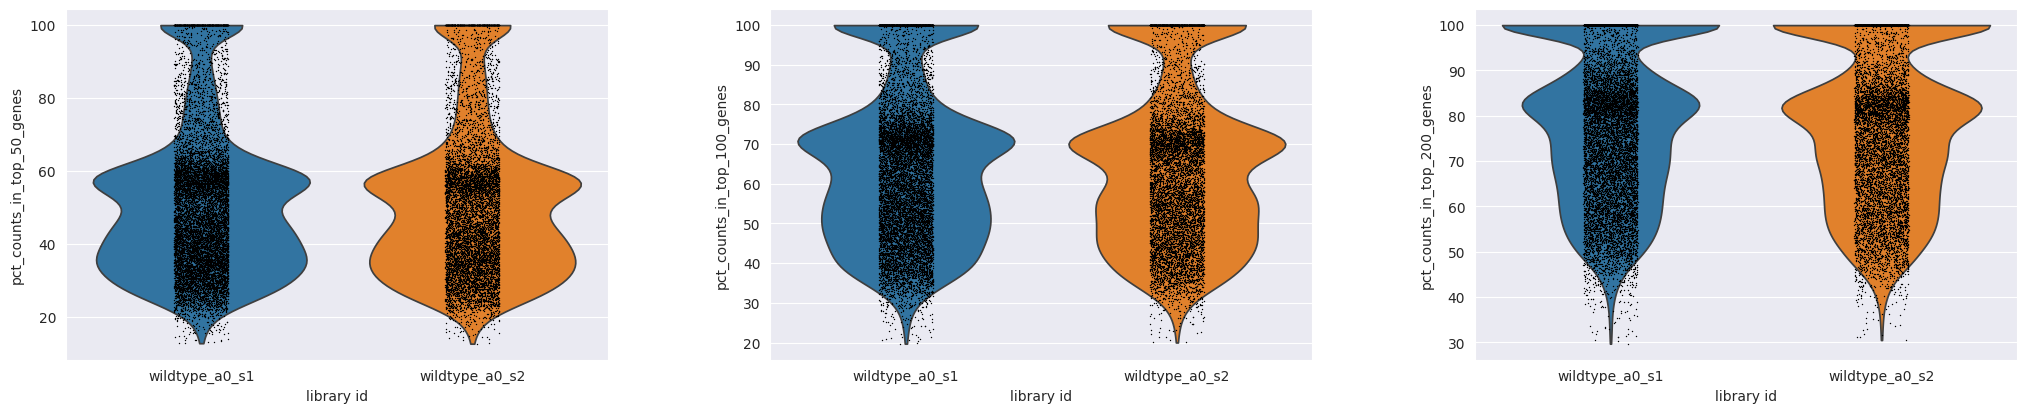

In [14]:
scanpy.pl.violin(
    adata,
    ["pct_counts_in_top_50_genes", "pct_counts_in_top_100_genes", "pct_counts_in_top_200_genes"],
    groupby="library_id",
    multi_panel=True,
)

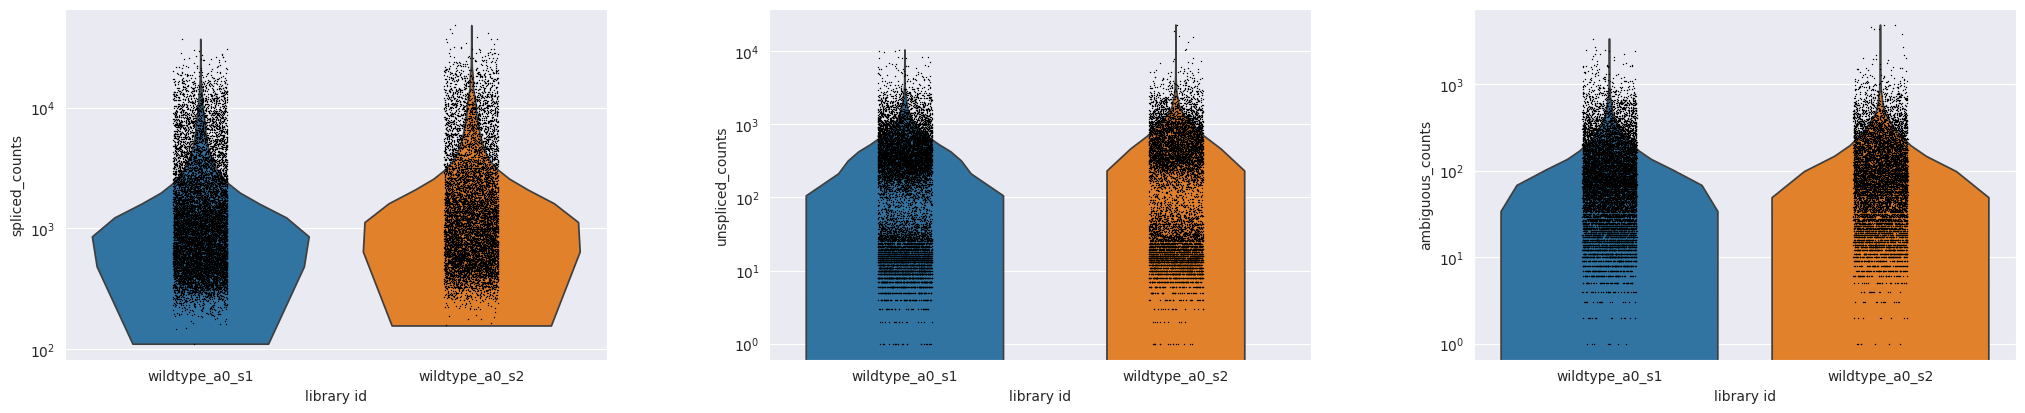

In [15]:
scanpy.pl.violin(
    adata,
    ["spliced_counts", "unspliced_counts", "ambiguous_counts"],
    log=True,
    groupby="library_id",
    multi_panel=True,
)

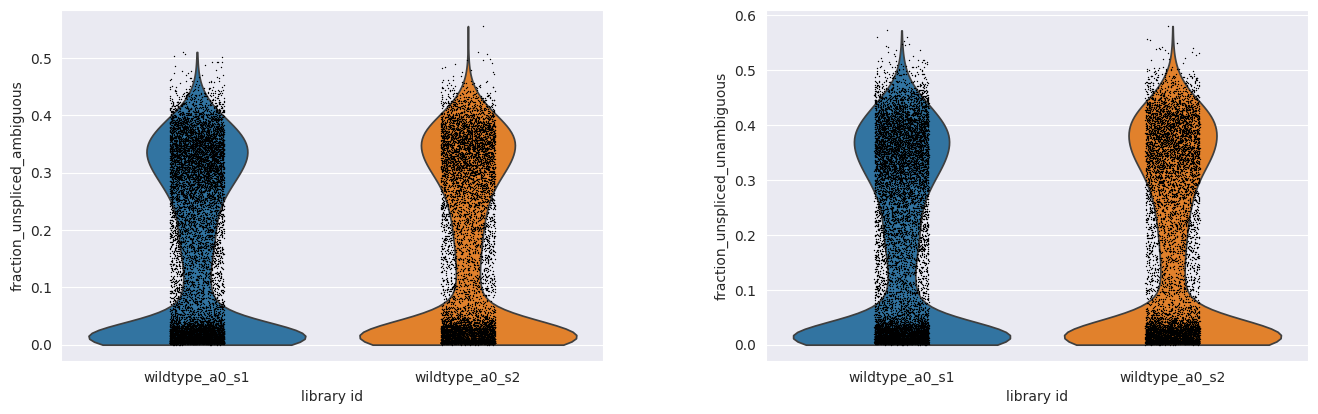

In [16]:
scanpy.pl.violin(
    adata,
    ["fraction_unspliced_ambiguous", "fraction_unspliced_unambiguous"],
    groupby="library_id",
    multi_panel=True,
)

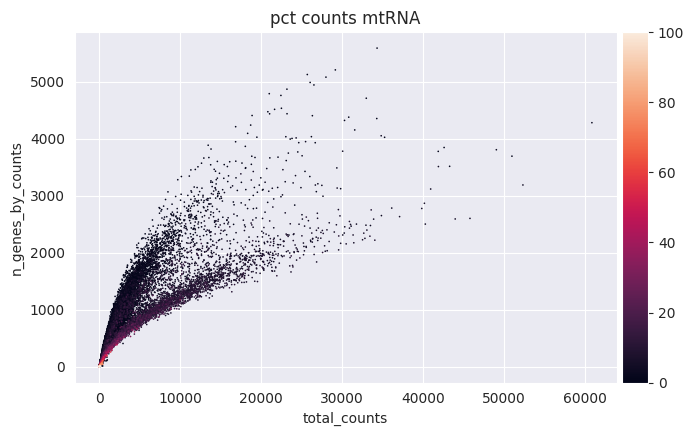

In [17]:
scanpy.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mtRNA")

In [18]:
adata

AnnData object with n_obs × n_vars = 20910 × 17607
    obs: 'library_id', 'genotype', 'stage', 'sample', 'study', 'spliced_counts', 'unspliced_counts', 'ambiguous_counts', 'fraction_unspliced_ambiguous', 'fraction_unspliced_unambiguous', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mtRNA', 'log1p_total_counts_mtRNA', 'pct_counts_mtRNA', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_ribo_protein', 'log1p_total_counts_ribo_protein', 'pct_counts_ribo_protein', 'total_counts_mito_ribo_protein', 'log1p_total_counts_mito_ribo_protein', 'pct_counts_mito_ribo_protein', 'total_counts_all_ribo_protein', 'log1p_total_counts_all_ribo_protein', 'pct_counts_all_ribo_protein'
    var: 'mtRNA', 'rRNA', 'ribo_protein', 'mito_ribo_protein', 'all_ribo_protein', 'n_cells_by_counts', 'mean_counts'

At this point, one would examine the plots we just made and filter anything questionable. There are a multitudinous thoughts on what should be filtered, but for now I am doing the bare minimum. I arbitrarily remove the highest count nuclei and the ones with the most genes expressed, as these are often doublets. There are several fancy doublet removal packages that would do a better job, but I haven't yet implemented them here. I also arbitrarily remove the nuclei with very low counts and genes expressed. These have too little information to form clusters well. You can also rerun the plots to see how whatever you removed changed them.

In [19]:
scanpy.pp.filter_cells(adata, max_counts=30000)
scanpy.pp.filter_cells(adata, max_genes=4000)

In [20]:
scanpy.pp.filter_cells(adata, min_genes=50)
scanpy.pp.filter_cells(adata, min_counts=100)

scanpy.pp.filter_genes(adata, min_cells=10)
scanpy.pp.filter_genes(adata, min_counts=10)

We save our progress here. Our choices as to what is or is not a nuclei are locked in. If you decide to remove more at any point after this (maybe you found an obviously artefactual cluster), you'll have to return to this step and remove them here then redo everything else, lest things break.

In [22]:
adata.write_h5ad("cluster_by_stage_filtered_only/" + out_file_prefix + ".h5ad")

In [ ]:
adata = anndata.read_h5ad("cluster_by_stage_filtered_only/" + out_file_prefix + ".h5ad")

In [23]:
adata

AnnData object with n_obs × n_vars = 19550 × 12376
    obs: 'library_id', 'genotype', 'stage', 'sample', 'study', 'spliced_counts', 'unspliced_counts', 'ambiguous_counts', 'fraction_unspliced_ambiguous', 'fraction_unspliced_unambiguous', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mtRNA', 'log1p_total_counts_mtRNA', 'pct_counts_mtRNA', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_ribo_protein', 'log1p_total_counts_ribo_protein', 'pct_counts_ribo_protein', 'total_counts_mito_ribo_protein', 'log1p_total_counts_mito_ribo_protein', 'pct_counts_mito_ribo_protein', 'total_counts_all_ribo_protein', 'log1p_total_counts_all_ribo_protein', 'pct_counts_all_ribo_protein', 'n_counts', 'n_genes'
    var: 'mtRNA', 'rRNA', 'ribo_protein', 'mito_ribo_protein', 'all_ribo_protein', 'n_cells_by

In [24]:
adata.obs["library_id"].value_counts(sort = False)

library_id
wildtype_a0_s1    11177
wildtype_a0_s2     8373
Name: count, dtype: int64

Store the raw counts, normalize, and log transform. It is extremely important to note that SCVI operates on the stored raw counts, but most other tools need the transformed ones. You will likely not get any obvious errors if you use the wrong one, but the results will be wrong, so double check.

In [25]:
adata.layers["counts"] = adata.X.copy()
adata.raw = adata.copy()
scanpy.pp.normalize_total(adata,
                          target_sum=1e6)
scanpy.pp.log1p(adata)

SCVI only operates on the highly variable genes. Here, I have set n_top_genes to a value much higher than the number of genes we have in order to use every gene. This way, we can perform differential expression using every gene later, but there are grave costs. Namely, this may reduce the efficacy of batch correction, and it increases runtimes considerably.

In [26]:
scanpy.pp.highly_variable_genes(adata,
                                n_top_genes=100000,
                                batch_key="library_id",
                                flavor="seurat_v3",
                                layer="counts",
                                subset=True)

We tell SCVI to use the raw counts, and correct for any batch effect between the two samples, which should be minimal to begin with.

In [27]:
scvi.model.SCVI.setup_anndata(adata,
                              layer="counts",
                              batch_key="library_id")

These are pretty much the default model hyperparameters. These could be optimized through hyperparameter tuning, but I haven't gotten around to it.

In [28]:
scvi_model = scvi.model.SCVI(adata,
                             n_hidden=128,
                             n_layers=2,
                             n_latent=10,
                             dispersion="gene")

We finally run the model. The first two lines are some settings to gain a little speed on our specific hardware. The training options enable logging, early stopping, and limit the number of epochs. max_epochs or other parameters may need to be changed depending on what the ELBO plot looks like.

In [29]:
scvi.settings.dl_num_workers = 35
torch.set_float32_matmul_precision("high")

scvi_model.train(max_epochs=40,
                 log_every_n_steps=1,
                 check_val_every_n_epoch=1,
                 early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/40 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


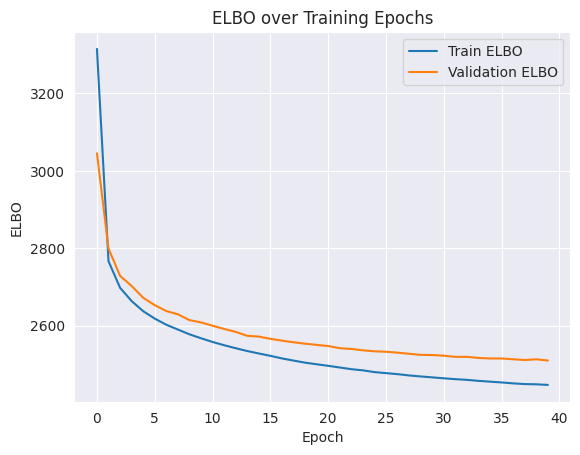

In [30]:
history = scvi_model.history
history.keys()
pyplot.plot(history["elbo_train"], label="Train ELBO")
pyplot.plot(history["elbo_validation"], label="Validation ELBO")
pyplot.xlabel("Epoch")
pyplot.ylabel("ELBO")
pyplot.title("ELBO over Training Epochs")
pyplot.legend()
pyplot.show()

Get the n_latent dimensional representation, on which we will create the nearest neighbors graph and UMAP and t-SNE embeddings.

In [31]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [32]:
scanpy.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)

In [33]:
scanpy.tl.umap(adata)

Before proceeding, ensure the library_id batches are well-mixed. If they aren't, you'll have to go back and change something(HVGs, hyperparameters, etc)

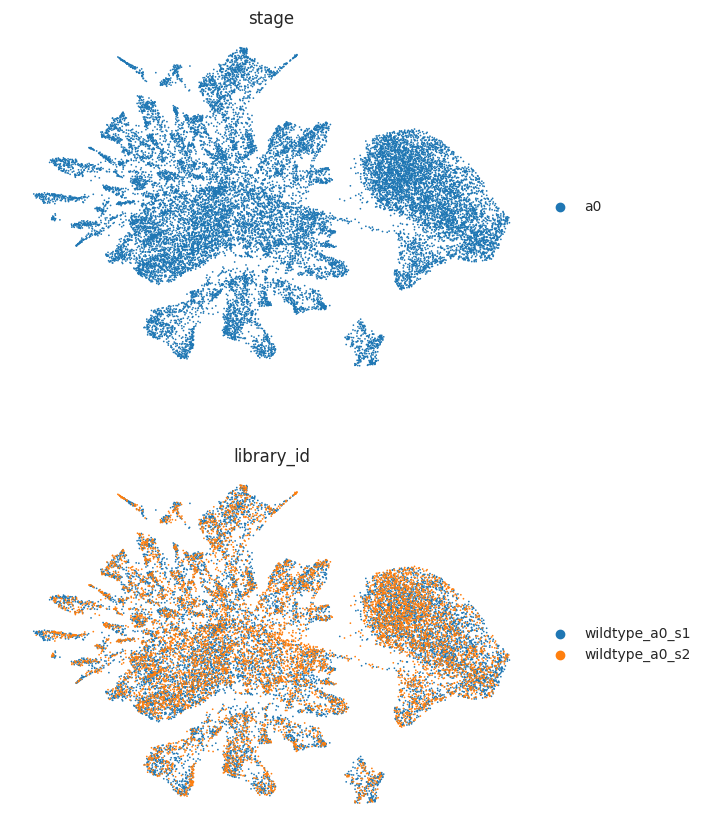

In [34]:
scanpy.pl.umap(
    adata,
    color=["stage", "library_id"],
    frameon=False,
    ncols=1,
)

Now we create the t-SNE embedding, which can take a while. Then we use it to visualize several QC metrics, from which you can decide if you want to go back and remove more nuclei.

In [35]:
scanpy.tl.tsne(adata,
           use_rep=SCVI_LATENT_KEY)

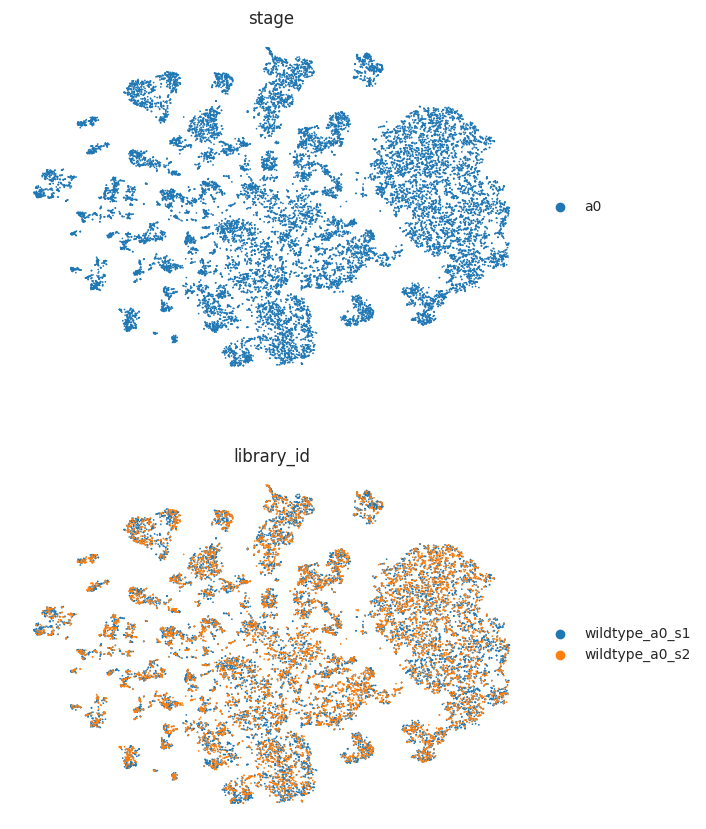

In [36]:
scanpy.pl.tsne(
    adata,
    color=["stage", "library_id"],
    frameon=False,
    ncols=1,
)

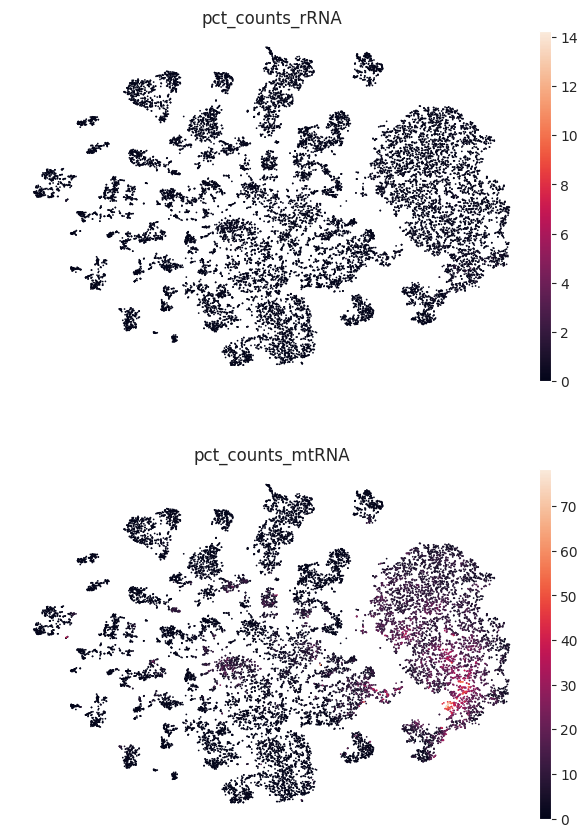

In [37]:
# note pct_counts_rRNA is artificially low since my gene list doesn't include pre-rRNA, maybe this should be called pct_counts_mature_rRNA
scanpy.pl.tsne(
    adata,
    color=["pct_counts_rRNA", "pct_counts_mtRNA"],
    frameon=False,
    ncols=1,
)

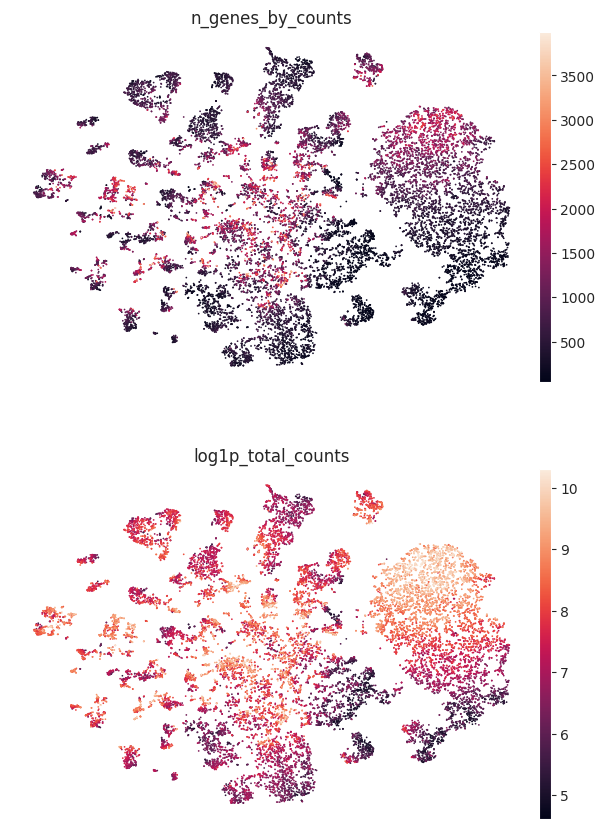

In [38]:
scanpy.pl.tsne(
    adata,
    color=["n_genes_by_counts", "log1p_total_counts"],
    frameon=False,
    ncols=1,
)

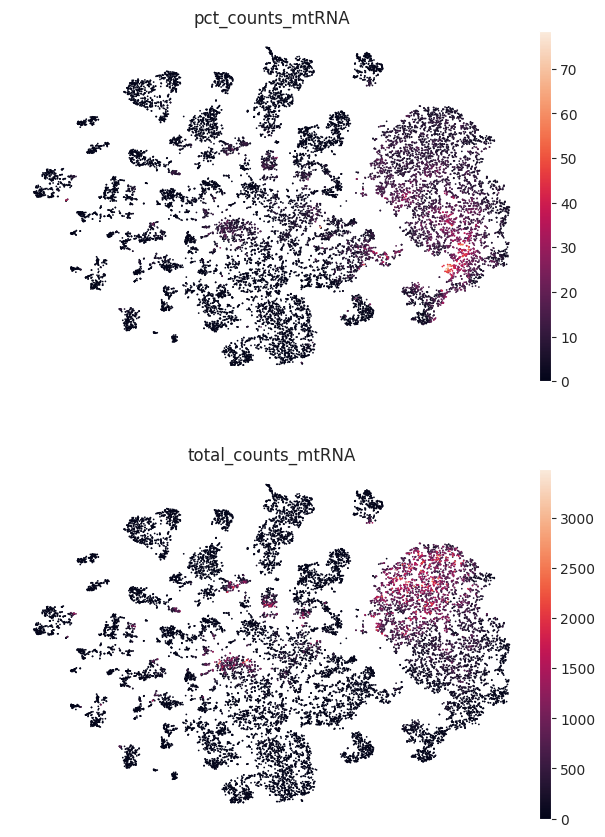

In [39]:
scanpy.pl.tsne(
    adata,
    color=["pct_counts_mtRNA", "total_counts_mtRNA"],
    frameon=False,
    ncols=1,
)

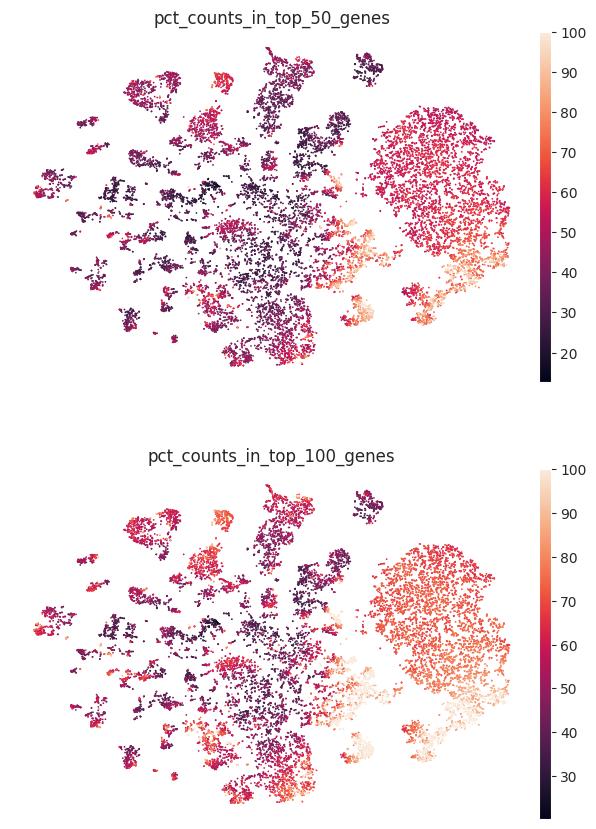

In [40]:
scanpy.pl.tsne(
    adata,
    color=["pct_counts_in_top_50_genes", "pct_counts_in_top_100_genes"],
    frameon=False,
    ncols=1,
)

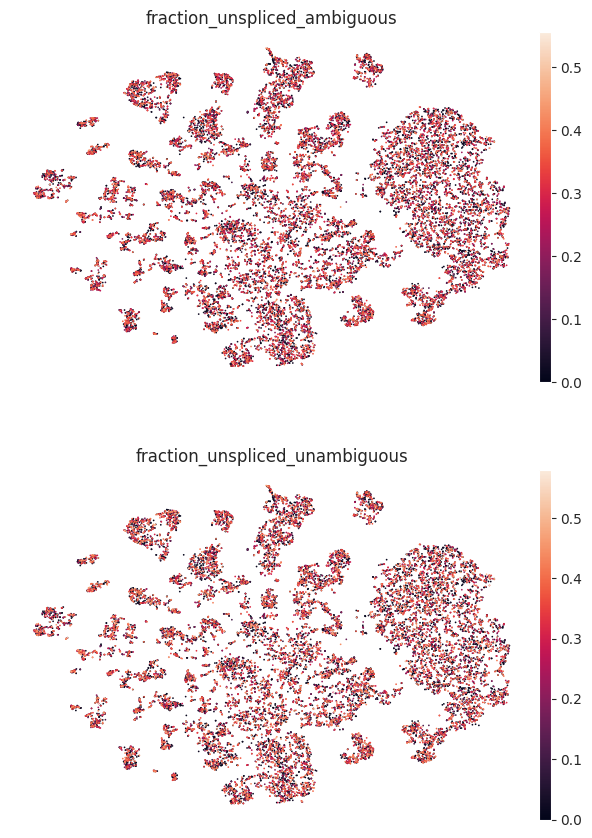

In [41]:
scanpy.pl.tsne(
    adata,
    color=["fraction_unspliced_ambiguous", "fraction_unspliced_unambiguous"],
    frameon=False,
    ncols=1,
)

If everything looks good, we create several more t-SNE embeddings with varying options. These can be useful for visualization.

In [43]:
scanpy.tl.tsne(adata,
               use_rep=SCVI_LATENT_KEY,
               perplexity=50,
               key_added="X_tsne_perp50")
scanpy.tl.tsne(adata,
               use_rep=SCVI_LATENT_KEY,
               early_exaggeration=24,
               key_added="X_tsne_ee24")
scanpy.tl.tsne(adata,
               use_rep=SCVI_LATENT_KEY,
               early_exaggeration=24,
               perplexity=50,
               key_added="X_tsne_perp50_ee24")
scanpy.tl.tsne(adata,
               use_rep=SCVI_LATENT_KEY,
               early_exaggeration=50,
               perplexity=100,
               key_added="X_tsne_perp100_ee50")

Perform Leiden clustering at various resolutions.

In [44]:
scanpy.tl.leiden(adata,
                 flavor="igraph",
                 resolution=0.5,
                 key_added="leiden_res0.5")
scanpy.tl.leiden(adata,
                 flavor="igraph",
                 resolution=1,
                 key_added="leiden_res1")
scanpy.tl.leiden(adata,
                 flavor="igraph",
                 resolution=2,
                 key_added="leiden_res2")
scanpy.tl.leiden(adata,
                 flavor="igraph",
                 resolution=5,
                 key_added="leiden_res5")
scanpy.tl.leiden(adata,
                 flavor="igraph",
                 resolution=10,
                 key_added="leiden_res10")

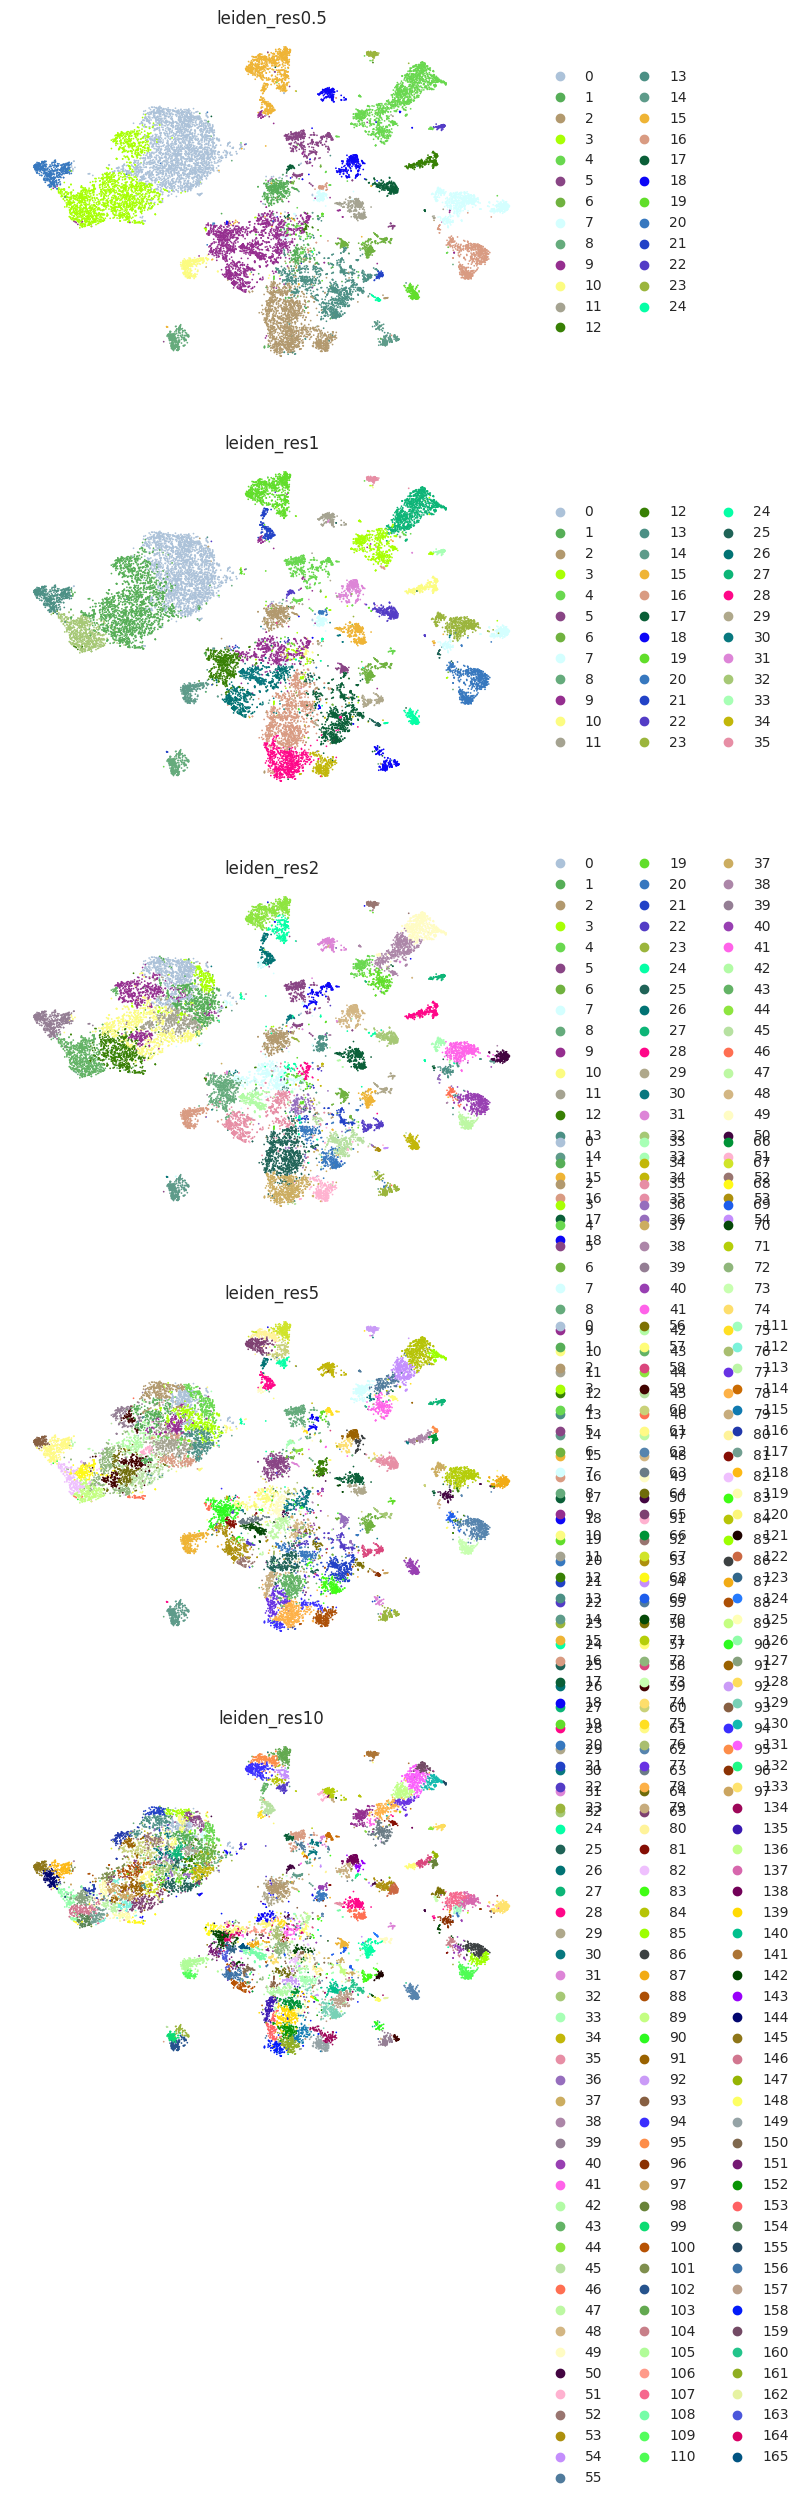

In [45]:
scanpy.pl.embedding(
    adata,
    basis="X_tsne_perp100_ee50",
    color=["leiden_res0.5", "leiden_res1", "leiden_res2", "leiden_res5", "leiden_res10"],
    frameon=False,
    ncols=1,
    palette=list(matplotlib.colors.XKCD_COLORS.values())
)

In [46]:
adata

AnnData object with n_obs × n_vars = 19550 × 12376
    obs: 'library_id', 'genotype', 'stage', 'sample', 'study', 'spliced_counts', 'unspliced_counts', 'ambiguous_counts', 'fraction_unspliced_ambiguous', 'fraction_unspliced_unambiguous', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mtRNA', 'log1p_total_counts_mtRNA', 'pct_counts_mtRNA', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_ribo_protein', 'log1p_total_counts_ribo_protein', 'pct_counts_ribo_protein', 'total_counts_mito_ribo_protein', 'log1p_total_counts_mito_ribo_protein', 'pct_counts_mito_ribo_protein', 'total_counts_all_ribo_protein', 'log1p_total_counts_all_ribo_protein', 'pct_counts_all_ribo_protein', 'n_counts', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_res0.5', 'leiden_res1', 'leiden_res2', 'leiden_res5', 

Now we prepare h5ads for use with cellxgene and Loupe Browser.

In [50]:
adata_cellxgene = adata.copy()

With so many Leiden clusters, the default colors can be hard to read and there may be more clusters than there are colors in the default palette. If you want, you can use custom colors, but here I just shuffle a premade palette until it looks OK.

In [53]:
colors = list(matplotlib.colors.XKCD_COLORS.values())
colors.remove("#000000")
random.shuffle(colors)

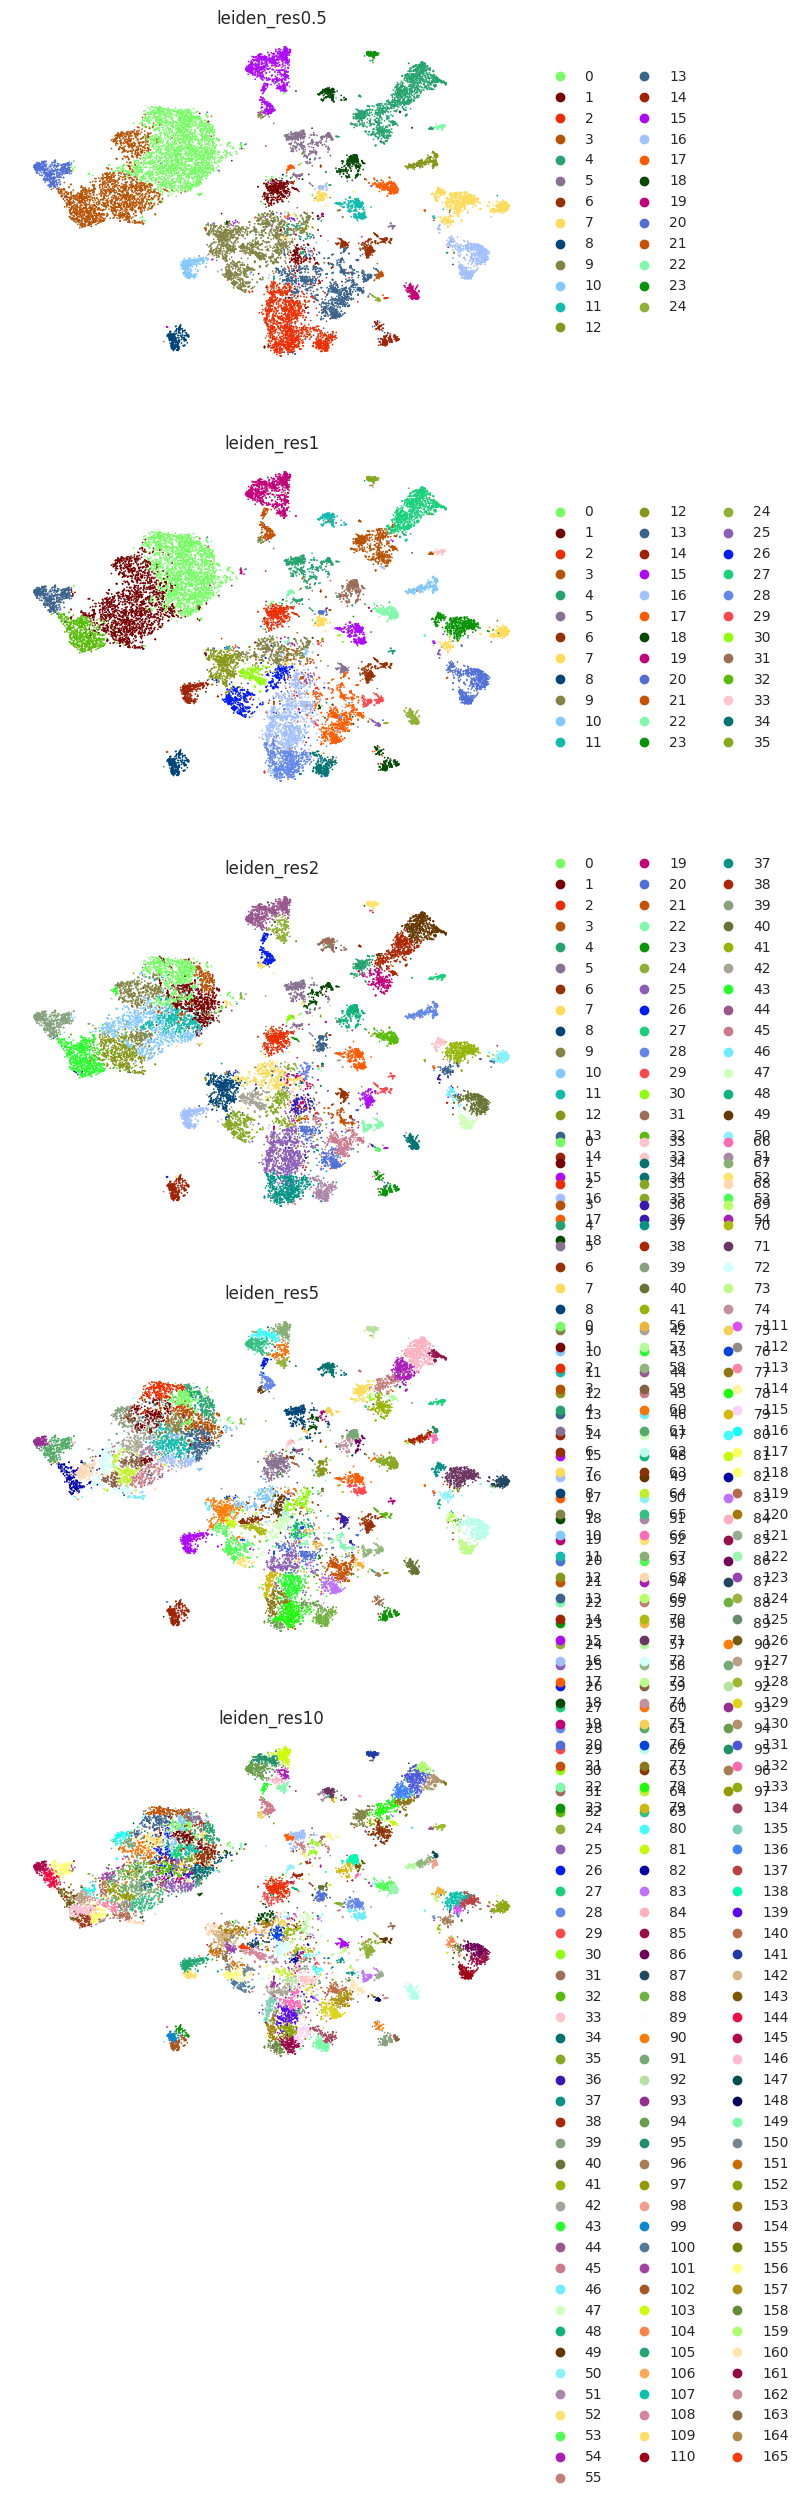

In [54]:
scanpy.pl.embedding(
    adata,
    basis="X_tsne_perp100_ee50",
    color=["leiden_res0.5", "leiden_res1", "leiden_res2", "leiden_res5", "leiden_res10"],
    frameon=False,
    ncols=1,
    palette=colors
)

In [55]:
adata_cellxgene.uns["leiden_res0.5_colors"] = colors
adata_cellxgene.uns["leiden_res1_colors"] = colors
adata_cellxgene.uns["leiden_res2_colors"] = colors
adata_cellxgene.uns["leiden_res5_colors"] = colors
adata_cellxgene.uns["leiden_res10_colors"] = colors

Since SCVI stores counts as probability distributions, we have to sample from those distributions to get our batch corrected matrices. Whatever is in adata.X beforehand is not batch corrected.

In [57]:
norm = scipy.sparse.csr_matrix(
    scvi_model.get_normalized_expression(adata,
                                         n_samples = 30,
                                         transform_batch = numpy.unique(adata.obs["library_id"]).tolist(),
                                         library_size = "latent",
                                         return_numpy=True
                                         ))

In [58]:
adata_cellxgene.X = norm

In [60]:
adata_cellxgene.write_h5ad("cluster_by_stage/cellxgene/" + out_file_prefix + ".h5ad")

Note Loupe Browser ignores the custom colors.

In [62]:
loupepy.create_loupe_from_anndata(adata_cellxgene,
                                  output_cloupe="cluster_by_stage/loupe/" + out_file_prefix + ".cloupe",
                                  force=True)

2025/11/18 09:27:21 validating input file: tmp.h5
2025/11/18 09:27:27 initializing loupe file: /tmp/1647504971.cloupe
2025/11/18 09:27:27 converting count matrix
2025/11/18 09:32:03 converting projections
2025/11/18 09:32:03 converting clusters
2025/11/18 09:32:04 finished loupe file: /tmp/1647504971.cloupe
2025/11/18 09:32:04 copying loupe file to: cluster_by_stage/loupe/wildtype_a0.cloupe
